# Batch Normalization

![Alt text](1.png)

![Alt text](2.png)

![Alt text](3.png)

![Alt text](4.png)

Training:

    1. Normalize layer activations according to mini-batch statistics.
    2. During the training step, update population statistics approximation via moving average of mini-batch statistics.

Testing:

    1. Normalize layer activations according to estimated population statistics.
    2. Do not update population statistics according to mini-batch statistcs from test data.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
%matplotlib inline

/Users/william/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
mnist = input_data.read_data_sets('../MNIST_data', one_hot=True)

Extracting ../MNIST_data/train-images-idx3-ubyte.gz
Extracting ../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../MNIST_data/t10k-labels-idx1-ubyte.gz


### tf.contrib.layers.batch_norm
http://ruishu.io/2016/12/27/batchnorm/

Note:
When `is_training` is True the `moving_mean` and `moving_variance` need to be updated, by default the `update_ops` are placed in `tf.GraphKeys.UPDATE_OPS` so they need to be added as a dependency to the `train_op`, example:

```python
x_norm = tf.layers.batch_normalization(x, training=training)

  # ...

  update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
  with tf.control_dependencies(update_ops):
    train_op = optimizer.minimize(loss)
```

In [3]:
def dense(x, size, activation, scope):
    with tf.variable_scope(scope):
        output = tf.contrib.layers.fully_connected(inputs=x, num_outputs=size, activation_fn=None, scope='dense')
        output = tf.nn.relu(output, name='relu') if activation=='relu' else output
        
        return output

def dense_batch_relu(x, size, phase, scope):
    with tf.variable_scope(scope):
        h1 = tf.contrib.layers.fully_connected(inputs=x, num_outputs=size, activation_fn=None, scope='dense')
        h2 = tf.contrib.layers.batch_norm(inputs=h1, center=True, scale=True, is_training=phase, scope='bn')
        output = tf.nn.relu(h2, name='relu')
        
        return output
    
def dense_relu_batch(x, size, phase, scope):
    with tf.variable_scope(scope):
        h1 = tf.contrib.layers.fully_connected(inputs=x, num_outputs=size, activation_fn=None, scope='dense')
        h2 = tf.nn.relu(h1, name='relu')
        output = tf.contrib.layers.batch_norm(inputs=h2, center=True, scale=True, is_training=phase, scope='bn')
        
        return output

In [4]:
accuracy_list = []
accuracy_bn_list = []
accuracy_post_bn_list = []

In [5]:
lr = 0.001
batch_size = 100
hidden_size = 100
iterep = 500

The `phase` term. We are going to use as a placeholder for a boolean which we will insert into `feed_dict`. It will serve as a binary indicator for whether we are in training `phase=True` or testing `phase=False` mode.

When you execute an operation (such as `train_step`), only the subgraph components relevant to `train_step` will be executed. Unfortunately, the `update_moving_averages` operation is not a parent of `train_step` in the computational graph, so we will never update the moving averages! To get around this, we have to explicitly tell the graph:

Hey graph, update the moving averages before you finish the training step!

Unfortunately, the instructions in the documentation are a little out of date. Furthermore, if you think about it a little more, you may conclude that attaching the `update` ops to `total_loss` may not be desirable if you wish to compute the `total_loss` of the test set during test time. Personally, I think it makes more sense to attach the `update` ops to the `train_step` itself. So I modified the code a little and created the following training function

In [6]:
for i in tqdm_notebook(range(3)):
    tf.reset_default_graph()
    
    ### input
    x = tf.placeholder(dtype='float32', shape=[None, 28*28], name='x')
    y = tf.placeholder(dtype='float32', shape=[None, 10], name='y')
    phase = tf.placeholder(dtype=tf.bool, name='phase')
    
    ### layers
    if i == 0:
        h1 = dense(x, hidden_size, 'relu', 'layer1')
        h2 = dense(h1, hidden_size, 'relu', 'layer2')
    elif i == 1:
        h1 = dense_batch_relu(x, hidden_size, phase, 'layer1')
        h2 = dense_batch_relu(h1, hidden_size, phase, 'layer2')
    else:
        h1 = dense_relu_batch(x, hidden_size, phase, 'layer1')
        h2 = dense_relu_batch(h1, hidden_size, phase, 'layer2')
    logits = dense(h2, 10, None, 'logits')
    
    ### output
    with tf.name_scope('loss'):
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=logits))
    with tf.name_scope('accuracy'):
        accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(y, 1), tf.argmax(logits, 1)), 'float32'))
    
    ### training
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        # Ensures that we execute the update_ops before performing the train_step
        train_step = tf.train.AdamOptimizer(lr).minimize(loss)
    
    history = []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        for j in tqdm_notebook(range(iterep * 30)):
            x_train, y_train = mnist.train.next_batch(batch_size)
            sess.run(train_step, feed_dict={x:x_train,
                                            y:y_train,
                                            phase:1})
            
            if (j+1) % iterep == 0:
                epoch = (j+1) / iterep
                train = sess.run([loss, accuracy], feed_dict={x:mnist.train.images,
                                                              y:mnist.train.labels,
                                                              phase:1})
                test  = sess.run([loss, accuracy], feed_dict={x:mnist.test.images,
                                                              y:mnist.test.labels,
                                                              phase:0})
                history += [[epoch] + train + test]
                
                if i == 0:
                    accuracy_list.append(test[-1])
                elif i == 1:
                    accuracy_bn_list.append(test[-1])
                else:
                    accuracy_post_bn_list.append(test[-1])
                
#                 print(history[-1])

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

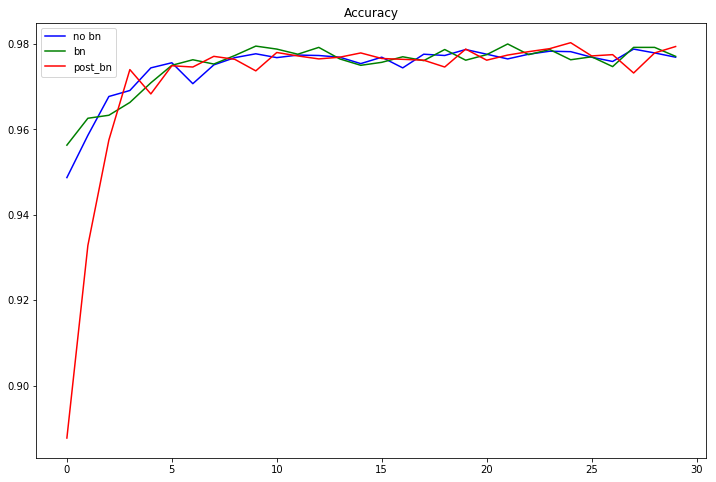

In [7]:
fig = plt.figure(figsize=(12, 8))
plt.plot(accuracy_list, 'b', label='no bn')
plt.plot(accuracy_bn_list, 'g', label='bn')
plt.plot(accuracy_post_bn_list, 'r', label='post_bn')
plt.title('Accuracy')
plt.legend()